## The purpose of the Capstone 1 project is to provide a list of recommendation to a gamer so that they may find new games that will interest them.

"Data Clean and EDA" will clean the data and perform exploratory data analysis.

The input needed for this code is review data in the form of dictionary which was produced using the "Data Pull" script

In [14]:
import pickle
loaded_df=pickle.load(open('final.p',"rb"))
steam_dict=pickle.load(open('steam.p',"rb"))

In [15]:
len(loaded_df)

340020

In [16]:
loaded_df.describe()

,comment_count,timestamp_created,timestamp_updated,votes_funny,votes_up,timestamp_dev_responded
count,340020.00000,3.400200e+05,3.400200e+05,3.400200e+05,340020.000000,5219.0
mean,0.41519,1.492251e+09,1.493911e+09,2.147372e+05,7.190921,0.0
std,4.00211,5.485052e+07,5.372798e+07,3.036840e+07,34.221430,0.0
min,0.00000,1.287217e+09,1.287266e+09,0.000000e+00,0.000000,0.0
25%,0.00000,1.456258e+09,1.457987e+09,0.000000e+00,1.000000,0.0
50%,0.00000,1.492246e+09,1.494819e+09,0.000000e+00,2.000000,0.0
75%,0.00000,1.537267e+09,1.538925e+09,1.000000e+00,6.000000,0.0
max,1285.00000,1.570408e+09,1.570433e+09,4.294967e+09,7262.000000,0.0


In [17]:
loaded_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340020 entries, 0 to 340019
Data columns (total 17 columns):
author                         340020 non-null object
comment_count                  340020 non-null float64
language                       340020 non-null object
received_for_free              340020 non-null object
recommendationid               340020 non-null object
review                         340020 non-null object
steam_purchase                 340020 non-null object
timestamp_created              340020 non-null float64
timestamp_updated              340020 non-null float64
voted_up                       340020 non-null object
votes_funny                    340020 non-null float64
votes_up                       340020 non-null float64
weighted_vote_score            340020 non-null object
written_during_early_access    340020 non-null object
game_name                      340020 non-null object
developer_response             5219 non-null object
timestamp_dev_responde

Check for duplicates and missing review content data

In [18]:
author_list=[author['steamid'] for author in list(loaded_df['author'])]
loaded_df['author']=author_list

In [19]:
review_df=loaded_df[['author','review','game_name']]

In [20]:
review_df.head()

,author,review,game_name
0,76561198013583343,I'm one of the lucky ducks who got to help tes...,Radio Violence
1,76561198284071338,Good DLC. Would have preferred more variety th...,Car Mechanic Simulator 2018 - Porsche DLC
2,76561197999475416,The Car Mechanic Simulator franchise takes a s...,Car Mechanic Simulator 2018 - Porsche DLC
3,76561198037828522,"Amazing new engines and cars addon, great DLC,...",Car Mechanic Simulator 2018 - Porsche DLC
4,76561197982995489,ENG:\n\nPorsche is my favorite car brand & so ...,Car Mechanic Simulator 2018 - Porsche DLC


In [12]:
names=list()
for row in range(len(review_df)):
    names.append(review_df['author'][row]['steamid'])

In [14]:
review_df['author']=names

/home/seo/environments/my_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [21]:
review_df=review_df.drop_duplicates()
review_df=review_df.dropna()

In [22]:
len(review_df)

338485

In [23]:
review_df.head(5)

,author,review,game_name
0,76561198013583343,I'm one of the lucky ducks who got to help tes...,Radio Violence
1,76561198284071338,Good DLC. Would have preferred more variety th...,Car Mechanic Simulator 2018 - Porsche DLC
2,76561197999475416,The Car Mechanic Simulator franchise takes a s...,Car Mechanic Simulator 2018 - Porsche DLC
3,76561198037828522,"Amazing new engines and cars addon, great DLC,...",Car Mechanic Simulator 2018 - Porsche DLC
4,76561197982995489,ENG:\n\nPorsche is my favorite car brand & so ...,Car Mechanic Simulator 2018 - Porsche DLC


In [35]:
steam_keys=list(steam_dict.keys())
steam_names=list(steam_dict.values())

In [36]:
game_ids=[steam_keys[steam_names.index(id_)] for id_ in list(review_df['game_name'])]

In [37]:
review_df['game_ids']=game_ids

In [38]:
import pickle
pickle.dump(review_df,open("cleaned_review.p","wb"))

In case a different language review is mixed in, detect language with langdetect and leave only the reviews written in english

In [39]:
from langdetect import detect, DetectorFactory
DetectorFactory.seed = 0

In [40]:
lang=list()
for num in range(len(review_df['review'])):
    try: 
        detected=detect(review_df['review'][num])
        lang.append(detected)
    except:
        lang.append('NaN')

In [41]:
review_df['detected_lang']=lang
review_df=review_df[review_df['detected_lang']=='en']

As this data does not include ratings for each reviews, a sentiment analysis using textblob was performed to assign the rating from 0 to 4 with 4 being the most positive.<br>

If the rating is larger than 2, the game is considered "recommended", and if the rating is smaller than 2, the game is considered "not recommended"
<br>
rating of 2 will be assigned NaN

In [42]:
from textblob import TextBlob

In [43]:
import numpy as np
review_sentiment=list()
review_recomd=list()
i=0
for review in review_df.review:
    sent = TextBlob(review)
    rating=round(2*(sent.sentiment.polarity+1))
    if sent.sentiment.polarity>0:
        recomd=True
    elif sent.sentiment.polarity<0:
        recomd=False
    else:
        recomd=np.nan
    review_sentiment.append(rating)
    review_recomd.append(recomd)

In [44]:
review_df['review_sentiment']=review_sentiment
review_df['recommend']=review_recomd

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
fig=plt.figure()
fig.set_facecolor('white')
sns.distplot(review_sentiment, hist=False).set_title('Rating distribution')

Text(0.5, 1.0, 'Rating distribution')

In [46]:
review_df

,author,review,game_name,game_ids,detected_lang,review_sentiment,recommend
0,76561198013583343,I'm one of the lucky ducks who got to help tes...,Radio Violence,947880,en,2,True
1,76561198284071338,Good DLC. Would have preferred more variety th...,Car Mechanic Simulator 2018 - Porsche DLC,947930,en,3,True
2,76561197999475416,The Car Mechanic Simulator franchise takes a s...,Car Mechanic Simulator 2018 - Porsche DLC,947930,en,2,True
3,76561198037828522,"Amazing new engines and cars addon, great DLC,...",Car Mechanic Simulator 2018 - Porsche DLC,947930,en,3,True
5,76561198314961129,It's great. I like the inclusion of rear engin...,Car Mechanic Simulator 2018 - Porsche DLC,947930,en,3,True
6,76561198058269515,I do wanna say before i say anything about the...,Car Mechanic Simulator 2018 - Porsche DLC,947930,en,2,True
7,76561198243655728,Finally you can see what a flat six engine loo...,Car Mechanic Simulator 2018 - Porsche DLC,947930,en,2,False
8,76561198021725803,I'm so happy when a DLC offers four licences c...,Car Mechanic Simulator 2018 - Porsche DLC,947930,en,2,True
9,76561198151617001,"Like many others have said, I woild like more ...",Car Mechanic Simulator 2018 - Porsche DLC,947930,en,3,True
10,76561198141659745,I've been searching for a Carrera GT in a shed...,Car Mechanic Simulator 2018 - Porsche DLC,947930,en,2,True


We will see if the length of the review is correlated to the sentiment of the reviewer.

In [47]:
good=review_df[review_df['recommend']==True]
bad=review_df[review_df['recommend']==False]

Text(0, 0.5, 'Number of reviews')

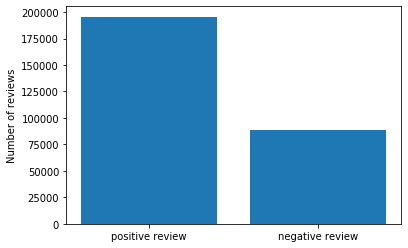

In [48]:
fig=plt.figure()
fig.set_facecolor('white')
plt.bar(['positive review','negative review'],[len(good),len(bad)])
plt.ylabel('Number of reviews')

In [49]:
print("There are",len(good),"positive reviews in my data")
print("There are",len(bad),"negative reviews in my data")

There are 195601 positive reviews in my data
There are 88646 negative reviews in my data


In [50]:
review_length=[len(review) for review in review_df['review']]
good_length=[len(review) for review in good['review']]
bad_length=[len(review) for review in bad['review']]

In [51]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

In [52]:
good_samples=np.random.normal(np.mean(good_length),np.std(good_length),size=100)
bad_samples=np.random.normal(np.mean(bad_length),np.std(bad_length),size=100)

Text(0.5, 1.0, 'ECDF of positive and negative review length')

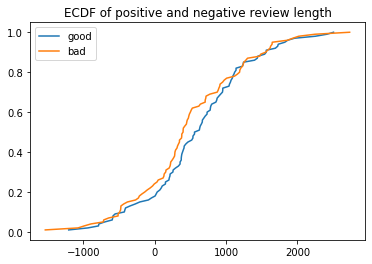

In [53]:
x_norm_good,y_norm_good=ecdf(good_samples)
x_norm_bad,y_norm_bad=ecdf(bad_samples)
fig=plt.figure()
fig.set_facecolor('white')
plt.plot(x_norm_good,y_norm_good,label="good")
plt.plot(x_norm_bad,y_norm_bad,label="bad")
plt.legend()
plt.title('ECDF of positive and negative review length')

/home/seo/environments/my_env/lib/python3.6/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/seo/environments/my_env/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


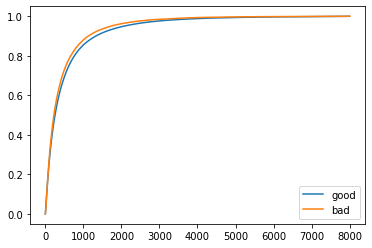

In [54]:
x_good,y_good=ecdf(good_length)
x_bad,y_bad=ecdf(bad_length)
plt.plot(x_good,y_good,label="good")
plt.plot(x_bad,y_bad,label="bad")
plt.legend()

In [55]:
from scipy.stats import ttest_ind
def checkttest(a,b):
    pval=ttest_ind(a,b).pvalue
    if pval<=0.01:
        print(pval,"Mean is different enough to be significant")
    else:
        print(pval, "Mean is too similar to be significant")

In [56]:
checkttest(bad_length,good_length)

4.2003248221736155e-118 Mean is different enough to be significant


By looking at the EDF graph, we can conclude that the good reviews tend to be longer than the bad ones

479.2735384013419


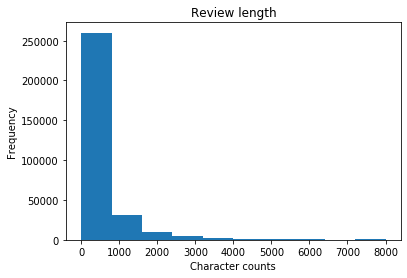

In [57]:
import matplotlib.pyplot as plt
import numpy as np

plt.hist(review_length)
plt.title('Review length')
plt.ylabel('Frequency')
plt.xlabel('Character counts')
print(np.mean(review_length))

The length of the review ranges from 0 to 8000 which is the maximum number of characters that is allowed in Steam store review

543.4551101476986


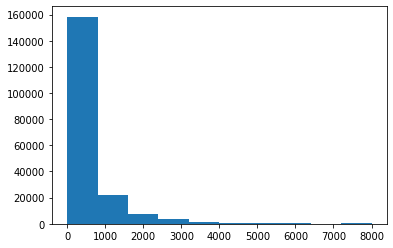

In [58]:
plt.hist(good_length)
print(np.mean(good_length))

468.9502290007445


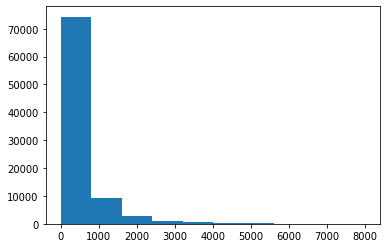

In [59]:
plt.hist(bad_length)
print(np.mean(bad_length))

                                                    review
game_name                                                 
TERA                                                   182
Hero-U: Rogue to Redemption                            100
Shadowverse                                            100
Stock Car Extreme                                      100
Super Mustache                                         100
Agarest Zero                                           100
PAYDAY 2: Hotline Miami                                100
Guacamelee! Gold Edition                                99
Caveman World: Mountains of Unga Boonga                 99
Guild Quest                                             99
Call of Duty: WWII - Multiplayer                        99
Green Hell                                              99
Drop Alive                                              99
Dirty Bomb                                              99
Tales from Space: Mutant Blobs Attack                   

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd8162f56a0>]],
      dtype=object)

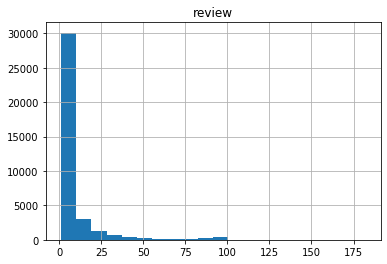

In [60]:
reviewnum=review_df.groupby(['game_name']).agg({'review':'count'})
reviewnum_new=reviewnum.reset_index().sort_values('review',ascending=False).set_index('game_name')
print(reviewnum_new[:100])
reviewnum_new.hist(bins=20)

                   review
author                   
76561198066590240     441
76561198069159152     412
76561198019816374     319
76561198137285867     289
76561197960373660     278
76561198440309009     207
76561198053422627     207
76561198048974498     174
76561198160868511     139
76561198120348301     137
                   review
author                   
76561198040273245       1
76561198040274244       1
76561198040274848       1
76561198040275876       1
76561198040278434       1
76561198040278708       1
76561198040279897       1
76561198040280331       1
76561198040280511       1
76561198994872691       1


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd81622a6a0>]],
      dtype=object)

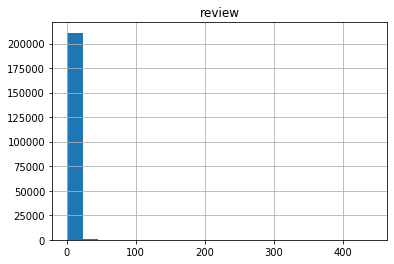

In [61]:
reviewauthor=review_df.groupby(['author']).agg({'review':'count'})
reviewauthor_new=reviewauthor.reset_index().sort_values('review',ascending=False).set_index('author')
reviewauthor_new.describe()
print(reviewauthor_new[0:10])
print(reviewauthor_new[-10:])
#plt.hist(reviewauthor_new)
reviewauthor_new.hist(bins=20)

                                         review
game_name                                      
TERA                                        182
Hero-U: Rogue to Redemption                 100
Shadowverse                                 100
Stock Car Extreme                           100
Super Mustache                              100
Agarest Zero                                100
PAYDAY 2: Hotline Miami                     100
Guacamelee! Gold Edition                     99
Caveman World: Mountains of Unga Boonga      99
Guild Quest                                  99
                                                    review
game_name                                                 
Slam                                                     1
Defense Clicker - Ressource Collector                    1
Defense Clicker - Auto Clicker Pet (Ice Elemental)       1
Defendoooooor!!                                          1
Hail To The King                                         1
Hail to the

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd816066c50>]],
      dtype=object)

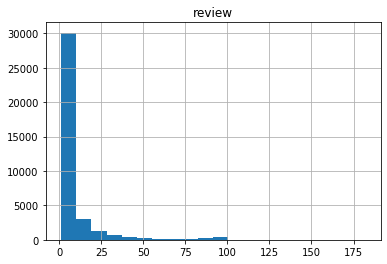

In [62]:
reviewgame=review_df.groupby(['game_name']).agg({'review':'count'})
reviewgame_new=reviewgame.reset_index().sort_values('review',ascending=False).set_index('game_name')
reviewgame_new.describe()
print(reviewgame_new[0:10])
print(reviewgame_new[-10:])
reviewgame_new.hist(bins=20)

In [63]:
import pickle
pickle.dump(review_df,open("cleaned_review_w_language.p","wb"))